In [1]:
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from rdm.util import custom_to_pil
from experiments_util import RETRIEVAL_DB_IMAGENET_METACLIP
from rdm.sample_generator import setup_model, format_args, SampleGenerator

def load_model(ckpt_path, config_path):
    config = OmegaConf.load(config_path)
    config.model.params.retrieval_cfg.params.load_patch_dataset = True
    config.model.params.retrieval_cfg.params.gpu = True
    # Load state dict
    pl_sd = torch.load(ckpt_path, map_location="cpu")
    # Initialize model
    model = instantiate_from_config(config.model)
    model.load_state_dict(pl_sd["state_dict"], strict=False)
    model = model.eval()
    device = torch.device("cuda:0")
    model.to(device)
    return model 



/private/home/lebensold/anaconda3/envs/dp_rdm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_DPRDM_ADAPT005_PATH = "/checkpoint/lebensold/rdm_aggsig005_last.ckpt"
model = load_model(MODEL_DPRDM_ADAPT005_PATH, RETRIEVAL_DB_IMAGENET_METACLIP)

MinimalRETRODiffusion: Running in eps-prediction mode
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
DiffusionWrapper has 400.92 M params.
Keeping EMAs of 690.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training MinimalRETRODiffusion as an unconditional model.
MinimalRETRODiffusion - agg: False, noise: 0.0, normalized embeddings: True 
RETRODiffusionWrapper: Wrapping diffusion model for RETRO training. For multimodal data, co

In [12]:
captions = [
    "A brown bear in the forest", 
    "A cute picture of a dog",
]
args = format_args(model, public_retrieval=False, 
                   captions=captions, 
                   k_nn=12, sigma=0.025, subsample_rate=1, aggregate=True, 
                   ddim_steps=100, guidance_scale=2., query_embedding_interpolation=1)
q = model.build_query(**args)

{'query': tensor([[-0.7198,  0.1152,  0.4367,  ...,  0.0605,  0.6562, -0.3100],
        [-0.3142,  0.1303,  0.3213,  ...,  0.2973,  0.2363, -0.0863]]), 'query_embedded': True, 'use_weights': False, 'ddim': True, 'visualize_nns': False, 'unconditional_retro_guidance_label': 0.0, 'k_nn': 12, 'unconditional_guidance_scale': 2.0, 'ddim_steps': 100, 'query_embedding_interpolation': 1, 'aggregate': True, 'public_retrieval': False, 'sigma': 0.025, 'return_nns': False, 'subsample_rate': 1}
subsampling 1
Query time: 0.2050948143005371s
Fetching: 0.00033354759216308594s
Getting Patches: 4.291534423828125e-06s
Query time: 0.2050948143005371s
Fetching: 0.00033354759216308594s
Getting Patches: 4.291534423828125e-06s


torch.Size([2, 12, 512])
Plotting: Switched to EMA weights
Using unconditonal diffusion guidance with scale 2.0
Data shape for DDIM sampling is (2, 3, 64, 64), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler:   1%|          | 1/100 [00:00<00:13,  7.19it/s]

DDIM Sampler: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Plotting: Restored training weights


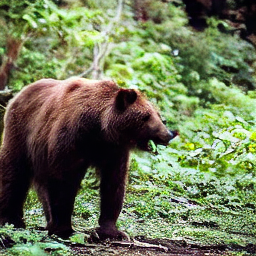

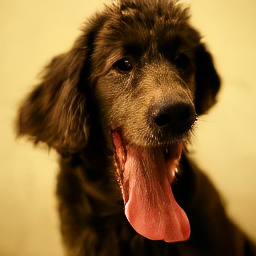

In [13]:
logs = model.sample_with_cached_query(**args, **q)
for idx,im in enumerate(logs['query_samples']):
    pilimg = custom_to_pil(im)
    display(pilimg)